<a href="https://colab.research.google.com/github/ninigapa0/SAMSUNG_ImageCaptioning/blob/main/ImageCaptioning_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install gdown

In [3]:
%cd
%cd /content/gdrive/MyDrive
import os
if not (os.path.isdir("SAMSUNG_ImageCaptioning")):
    os.mkdir("SAMSUNG_ImageCaptioning")
% cd SAMSUNG_ImageCaptioning



#Download pretrained weights, test sets
!gdown --id 1d5K2tSHPyLFyNiR-F__zxCIXqAMJDCk2

/root
/content/gdrive/MyDrive
/content/gdrive/MyDrive/SAMSUNG_ImageCaptioning
Downloading...
From: https://drive.google.com/uc?id=1d5K2tSHPyLFyNiR-F__zxCIXqAMJDCk2
To: /content/gdrive/MyDrive/SAMSUNG_ImageCaptioning/SAMSUNG_ImageCaptioning.zip
755MB [00:05, 147MB/s]


In [4]:
!unzip -o SAMSUNG_ImageCaptioning.zip

Archive:  SAMSUNG_ImageCaptioning.zip
  inflating: models.py               
  inflating: WORDMAP_coco_5_cap_per_img_5_min_word_freq.json  
  inflating: BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar  


Import Libraries

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from skimage import io
from PIL import Image
import cv2
import warnings
import requests
from models import Encoder as Encoder_answer
from models import Attention as Attention_answer
from models import DecoderWithAttention as Decoder_answer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Load word map (word2ix)
word_map='WORDMAP_coco_5_cap_per_img_5_min_word_freq.json'
with open(word_map, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word
 


cuda


In [7]:
#Fix seed
random_seed=0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

1.Implement Models


Encoder

In [8]:
class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


Attention


In [9]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        embedding1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        embedding2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(embedding1 + embedding2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

Decoder

In [10]:
class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.
        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [11]:
# Model parameters
embed_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5

import copy


encoder=Encoder().to(device)
encoder.eval()
decoder=DecoderWithAttention(attention_dim=attention_dim, embed_dim=embed_dim, decoder_dim=decoder_dim, vocab_size=len(word_map)).to(device)
decoder.eval()


encoder_answer=Encoder_answer().to(device)
encoder_answer.eval()

decoder_answer=Decoder_answer(attention_dim=attention_dim, embed_dim=embed_dim, decoder_dim=decoder_dim, vocab_size=len(word_map)).to(device)
decoder_answer.eval()

def make_parameters_same(net,answer):
  state_dict=net.state_dict()
  for name,weights in answer.named_parameters():
    state_dict[name]=weights
  net.load_state_dict(state_dict)
  return net

encoder=make_parameters_same(encoder,encoder_answer)
decoder=make_parameters_same(decoder,decoder_answer)


#Check Encoder
img=torch.randn(5,3,256,256).to(device)
encoder_out1=encoder(img)
encoder_out2=encoder_answer(img)
if (abs(encoder_out1-encoder_out2).sum()==0):
  print("Valid Encoder!!")
  #Check Decoder
  captions=torch.randint(0,10,(5,13),dtype=int).to(device)
  caption_lengths=torch.randint(0,10,(5,1),dtype=int).to(device)
  a0,a1,a2,a3,a4=decoder(encoder_out1.detach().clone(),copy.deepcopy(captions),copy.deepcopy(caption_lengths))
  b0,b1,b2,b3,b4=decoder_answer(encoder_out1,captions,caption_lengths)
  if ((abs(a0-b0).sum()+abs(a1-b1).sum()+abs(a3-b3).sum()+abs(a4-b4).sum())==0):
    print("Valid Decoder!!")
  else:
    print("Need to fix Decoder")


else:
  print("Need to fix Encoder")





Valid Encoder!!
Valid Decoder!!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2.Implement beam search

In [12]:
def caption_image_beam_search(encoder, decoder, url, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param url: url of  image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process

    image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
    img = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)

    #img = io.imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = skimage.transform.resize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    #img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)
        prev_word_inds = prev_word_inds.type(torch.LongTensor).to(device)
        next_word_inds = next_word_inds.type(torch.LongTensor).to(device)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas

In [13]:
def visualize_att(image, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    #image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

Load pretrained model

In [14]:





warnings.filterwarnings(action='ignore') 
MODEL_PATH='BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar'


# Load model
checkpoint = torch.load(MODEL_PATH, map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()


warnings.filterwarnings(action='default') 

In [15]:
def caption_image( url,beam_size,encoder, decoder, word_map, rev_word_map):
  img = Image.open(requests.get(url, stream=True).raw)

  # Encode, decode with attention and beam search
  seq, alphas = caption_image_beam_search(encoder, decoder, url, word_map, beam_size)
  alphas = torch.FloatTensor(alphas)

  # Visualize caption and attention of best sequence
  visualize_att(img, seq, alphas, rev_word_map,True)
  warnings.filterwarnings(action='default') 

Check the image captioning

Get image url from internet( ex) https://cocodataset.org/#explore)


/usr/local/lib/python3.7/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)


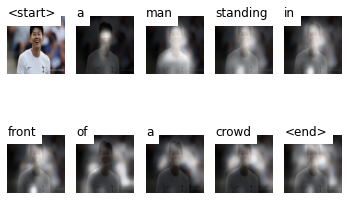

In [16]:
caption_image(url="https://img4.yna.co.kr/photo/reuters/2021/07/22/PRU20210722044001055_P4.jpg",beam_size=25,encoder=encoder,decoder=decoder,word_map=word_map, rev_word_map=rev_word_map)

http://farm7.staticflickr.com/6231/6305552632_06eedb5a50_z.jpg


/usr/local/lib/python3.7/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)


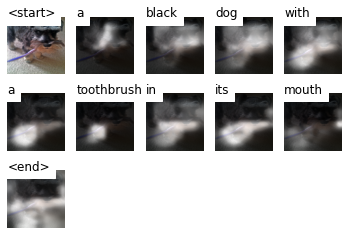

In [18]:
url=input()
caption_image(url=url,beam_size=25,encoder=encoder,decoder=decoder,word_map=word_map, rev_word_map=rev_word_map)